In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
sns.set(style="whitegrid")

In [2]:
df = pd.read_excel("flight_price.xlsx")
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.dropna(inplace=True)

df["Date_of_Journey"] = pd.to_datetime(df["Date_of_Journey"], dayfirst=True)
df["Journey_Day"] = df["Date_of_Journey"].dt.day
df["Journey_Month"] = df["Date_of_Journey"].dt.month
df.drop("Date_of_Journey", axis=1, inplace=True)

def duration_to_min(x):
    h = int(x.split('h')[0]) if 'h' in x else 0
    m = int(x.split('h')[-1].replace('m','')) if 'm' in x else 0
    return h*60 + m
df["Duration_Minutes"] = df["Duration"].apply(duration_to_min)
df.drop("Duration", axis=1, inplace=True)

mapping = {'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4, np.nan:1}
df['Total_Stops'] = df['Total_Stops'].map(mapping)

df.drop(['Route','Additional_Info'], axis=1, inplace=True)

df.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Price,Journey_Day,Journey_Month,Duration_Minutes
0,IndiGo,Banglore,New Delhi,22:20,01:10 22 Mar,0,3897,24,3,170
1,Air India,Kolkata,Banglore,05:50,13:15,2,7662,1,5,445
2,Jet Airways,Delhi,Cochin,09:25,04:25 10 Jun,2,13882,9,6,1140
3,IndiGo,Kolkata,Banglore,18:05,23:30,1,6218,12,5,325
4,IndiGo,Banglore,New Delhi,16:50,21:35,1,13302,1,3,285


In [4]:
## EDA & Visualizations

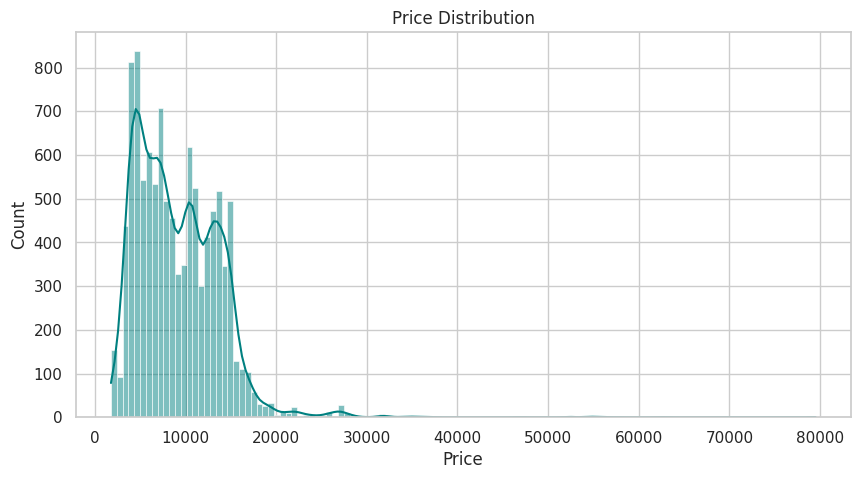

In [5]:
# Price Distribution
plt.figure(figsize=(10,5))
sns.histplot(df['Price'], kde=True, color='teal')
plt.title("Price Distribution")
plt.show()

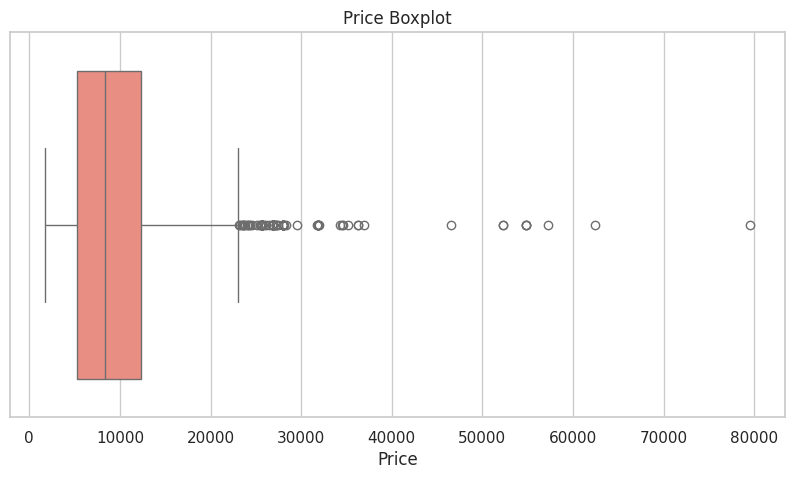

In [6]:
# Price Boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x=df['Price'], color='salmon')
plt.title("Price Boxplot")
plt.show()

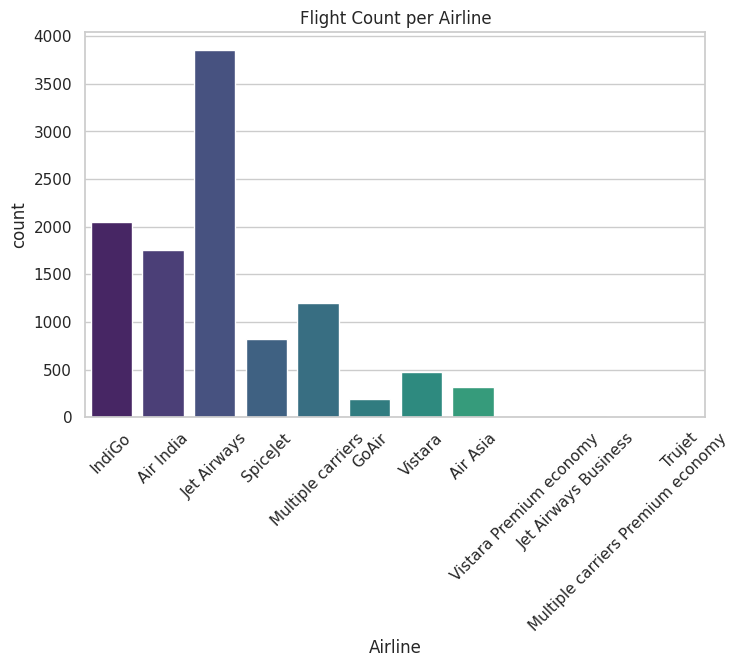

In [7]:
# Airline Countplot
plt.figure(figsize=(8,5))
sns.countplot(x='Airline', data=df, palette='viridis')
plt.xticks(rotation=45)
plt.title("Flight Count per Airline")
plt.show()

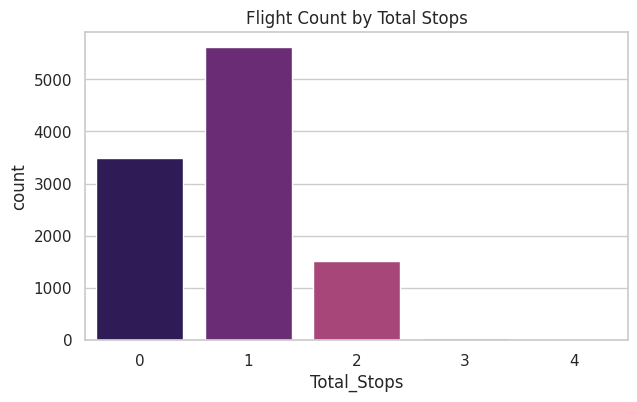

In [8]:
# Stops Countplot
plt.figure(figsize=(7,4))
sns.countplot(x='Total_Stops', data=df, palette='magma')
plt.title("Flight Count by Total Stops")
plt.show()


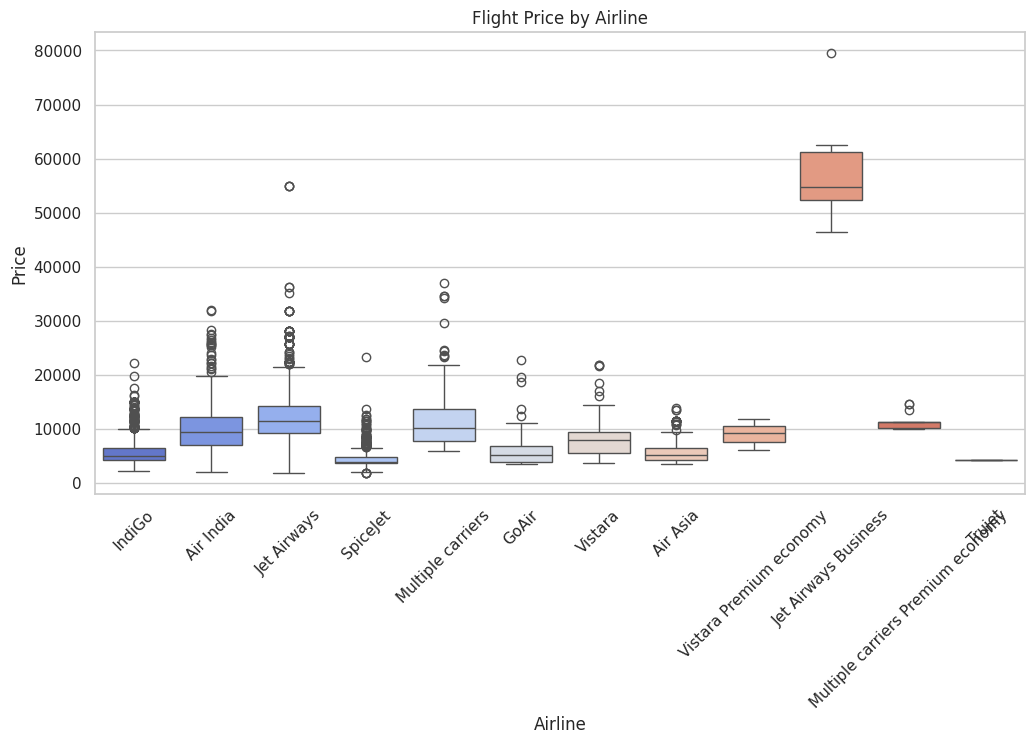

In [9]:
# Boxplot: Price vs Airline
plt.figure(figsize=(12,6))
sns.boxplot(x='Airline', y='Price', data=df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Flight Price by Airline")
plt.show()

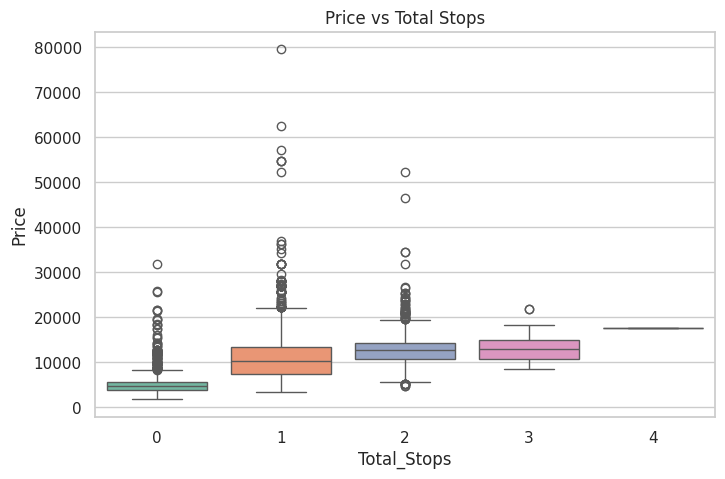

In [10]:
# Boxplot: Price vs Stops
plt.figure(figsize=(8,5))
sns.boxplot(x='Total_Stops', y='Price', data=df, palette='Set2')
plt.title("Price vs Total Stops")
plt.show()

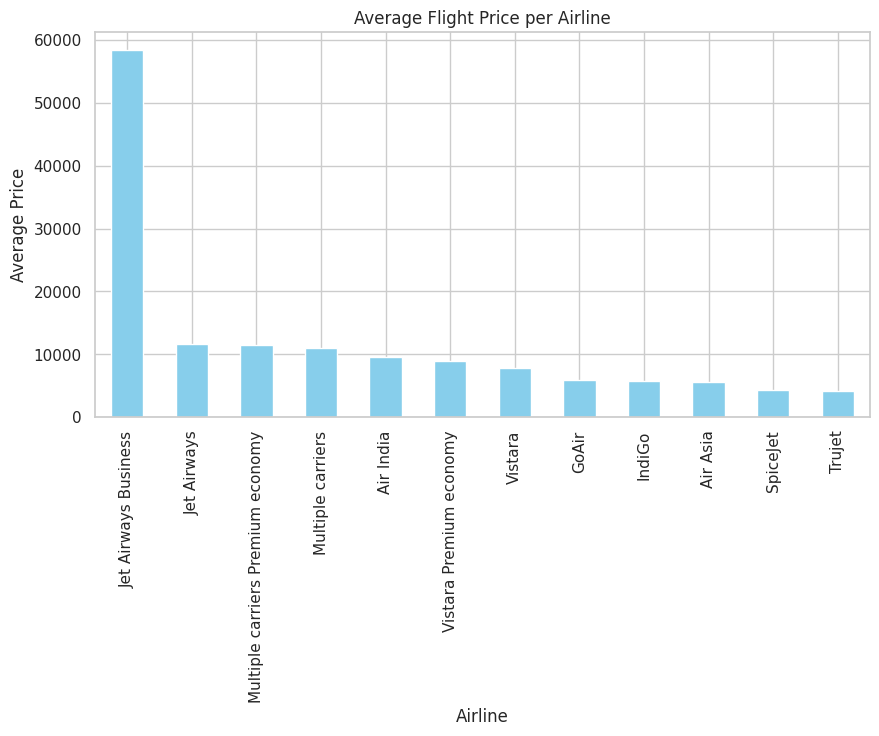

In [11]:
# Avg Price per Airline - Bar Plot
plt.figure(figsize=(10,5))
df.groupby('Airline')['Price'].mean().sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Average Flight Price per Airline")
plt.ylabel("Average Price")
plt.show()

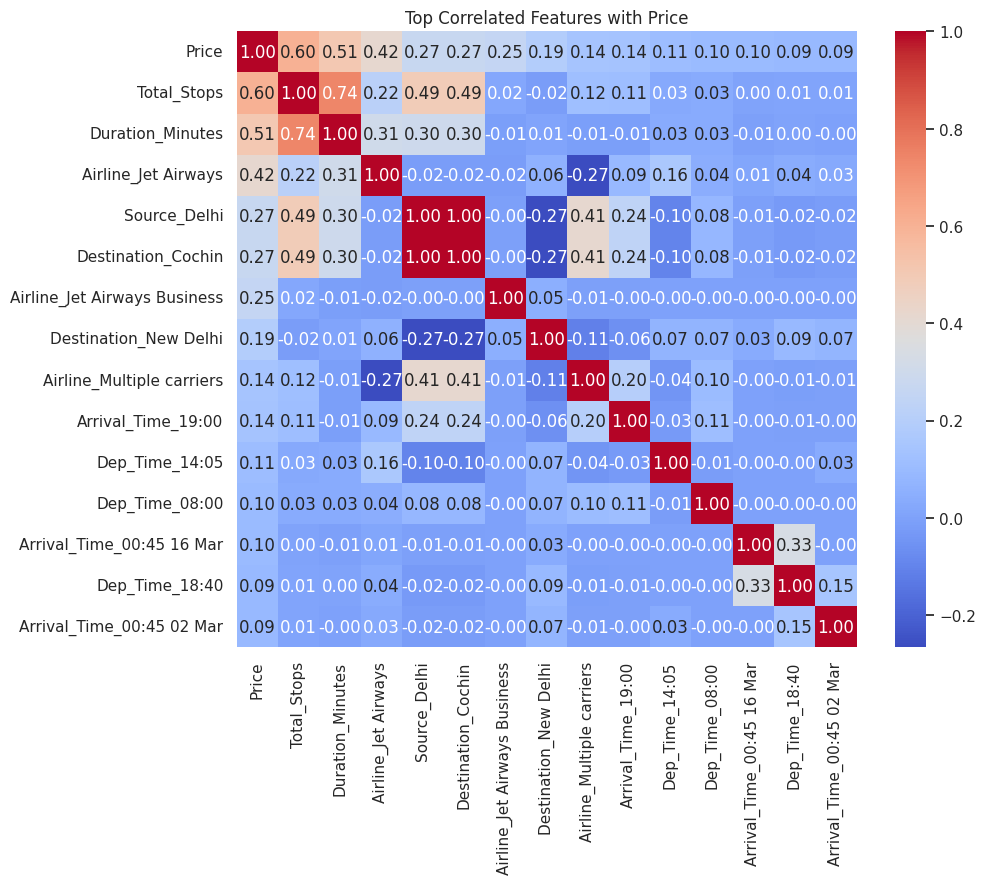

In [12]:
# Correlation Heatmap
df_encoded = pd.get_dummies(df, drop_first=True)

# Take only top correlated features with Price
corr = df_encoded.corr()['Price'].sort_values(ascending=False)
top_features = corr.head(15).index

plt.figure(figsize=(10,8))
sns.heatmap(df_encoded[top_features].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Correlated Features with Price")
plt.show()

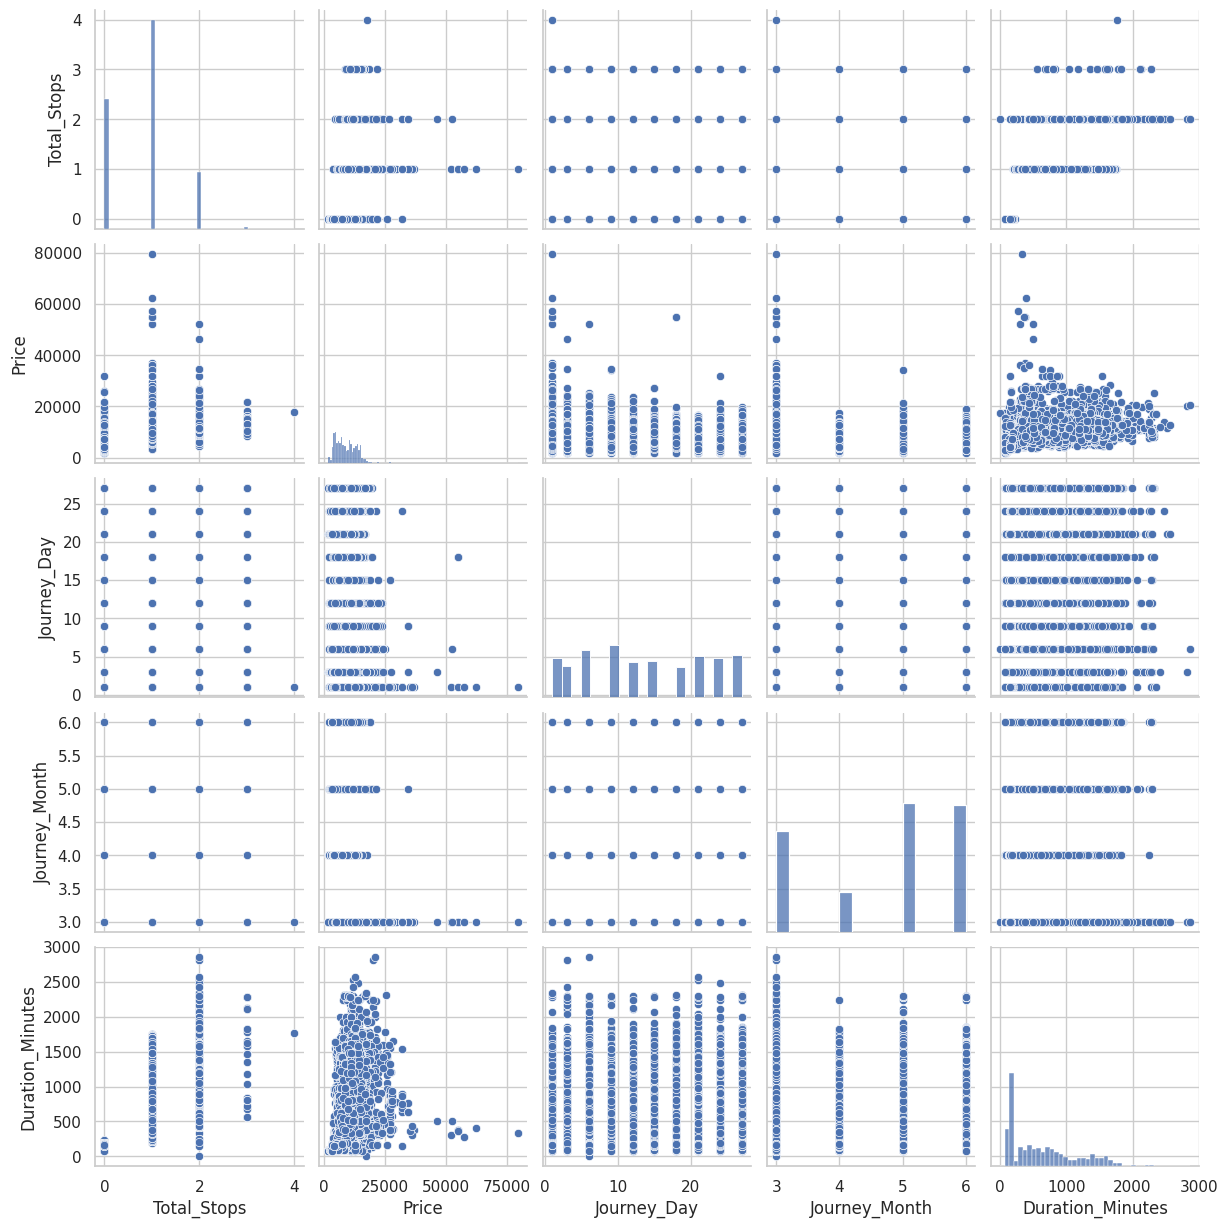

In [13]:
# Pairplot
numeric_cols = df_encoded.select_dtypes(include=np.number).columns
sns.pairplot(df_encoded[numeric_cols])
plt.show()

In [14]:
# Prepare Data
X = df_encoded.drop("Price", axis=1)
y = df_encoded["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (8545, 1587)
Test shape: (2137, 1587)


In [15]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [16]:
print("Linear Regression Results")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2:", r2_score(y_test, y_pred_lr))

Linear Regression Results
MAE: 1660.3867605051798
RMSE: 2540.462452353667
R2: 0.7006802424225788


In [17]:
# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [18]:
print("Random Forest Results")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))

Random Forest Results
MAE: 1151.500955401245
RMSE: 1986.2783721317176
R2: 0.8170257181279487


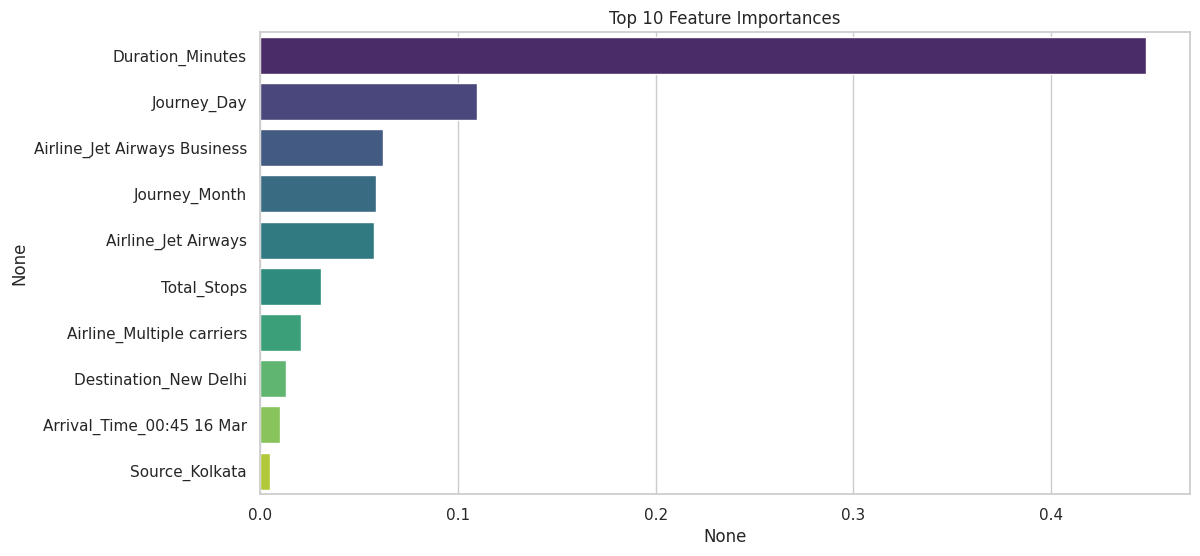

In [19]:
# Feature Importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp.head(10), y=feat_imp.head(10).index, palette='viridis')
plt.title("Top 10 Feature Importances")
plt.show()

In [20]:
# Hyperparameter Tuning (RandomizedSearchCV)
param_grid = {
    'n_estimators':[100,200,300],
    'max_depth':[None,10,20,30],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2]
}
rf_base = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best Params:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30}


In [21]:
# Evaluate Tuned Model
y_pred_best = best_model.predict(X_test)
print("Tuned Random Forest Results")
print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R2:", r2_score(y_test, y_pred_best))

Tuned Random Forest Results
MAE: 1136.179231857627
RMSE: 2052.3643256011264
R2: 0.8046476058834842


In [22]:
# Cross Validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("CV Scores:", cv_scores)
print("Average CV Score:", cv_scores.mean())

CV Scores: [0.79836187 0.80193536 0.8453615  0.83278038 0.79239968]
Average CV Score: 0.8141677587077283


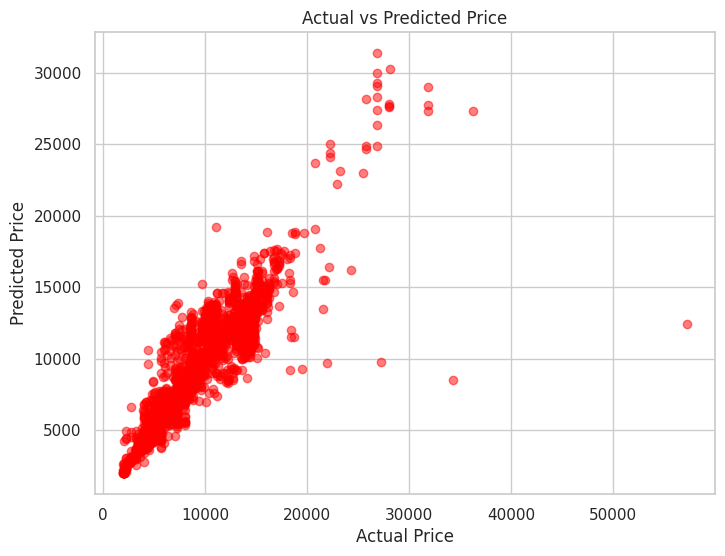

In [23]:
# Actual vs Predicted Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.5, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

In [24]:
# Save Model
with open("flight_price_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("Model saved successfully!")

Model saved successfully!
